In [142]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import sys
import os
from src.model import AveragingModel
import xgboost as xgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


path = '/home/alexandr/Desktop/study/boosterspro/happy_data_year_rosbank/'
sys.path.append(path) if not path in sys.path else None

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [87]:
train = pd.read_csv(path+'data/input/train.csv', index_col=0)

In [88]:
test = pd.read_csv(path+'data/input/test.csv', index_col=0)

In [89]:
train['isTrain'] = True
test['isTrain'] = False

In [90]:
X = train.append(test, sort=False)

In [91]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8765.0,4404.586366,2542.532548,1.000000,2207.000000,4403.000000,6603.000000,8811.000000
atm_group,8765.0,4407.008842,2427.934099,32.000000,1942.000000,5478.000000,5478.000000,8083.000000
lat,8345.0,54.138304,4.329293,42.057080,52.243997,55.060936,56.116673,69.495093
long,8345.0,63.500873,32.787366,19.941530,37.851107,49.071694,84.950218,173.706490
target,6261.0,0.000715,0.085852,-0.145001,-0.061176,-0.015573,0.040149,0.218608


In [92]:
X.describe(include='object').T

,count,unique,top,freq
address,8765,7481,"HOROSHEVSKOE SH,V38 MOSKVA",7
address_rus,8345,6147,"квартал В-13, городской округ Волгодонск, Рост...",10


### Количество банкоматов стоящих по одному адресу

In [93]:
counts = X.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count'})

In [94]:
X = pd.merge(X, counts, how='left', on='address_rus')

In [95]:
X.head()

,id,atm_group,address,address_rus,lat,long,target,isTrain,count
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True,1.0
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True,1.0
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,True,1.0
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,True,1.0
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,True,1.0


### Расстояния до ближайших банкоматов

In [96]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [97]:
knc = KNeighborsClassifier(metric=distance)

In [98]:
dots = X[['lat','long']].dropna()

,lat,long
0,46.940995,142.738319
1,46.937353,142.753348
2,46.959413,142.741113
3,55.805827,37.515146
4,69.343541,88.211228
5,43.165860,131.908212
6,55.716859,37.613063
7,43.117174,131.885503
8,55.799765,37.116016
9,53.203220,44.978826


In [99]:
knc.fit(X=dots , y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x7f3985d2fe18>,
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [100]:
distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

In [101]:
for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

In [102]:
dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)
dots = dots.drop(columns=['lat', 'long'])

In [103]:
X = pd.concat([X,dots], axis=1)

### Город размещения

In [104]:
X['city'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2]) 

In [105]:
rare_cities = X.city.value_counts()[(X.city.value_counts() < 20) ==True].index

In [106]:
X.city = X.city.apply(lambda x: 'RARE' if x in rare_cities else x)

In [107]:
X.city= X.city.rank().fillna(-1)

In [108]:
X_ = X[X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                    'distance_2',  'distance_3',  'distance_4', 'distance_5',
                    'indexes_5', 'mean', 'city']]
Y_ = X.loc[X.isTrain, 'target']

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.25, random_state=1)
X_train.head(3)

## LightGBM

In [134]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.25, random_state=1)
def train(depth=12, n_estimators=1000):
    gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = depth,
                            num_iterations=10000,
                            learning_rate = 0.1,
                            num_leaves = 2**(depth-1),
                            boosting = 'gbdt',
                            n_estimators = n_estimators)
    gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5)
    score = rmse(Y_valid, gbm.predict(X_valid))
    return gbm, score
scores = []
models = []
for depth in tqdm_notebook(range(3, 12)):
    model, score = train(depth)
    models.append(model)
    scores.append(score)
    
opt_depth = 5+np.argmin(scores)
gbm_model = models[np.argmin(scores)]

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.00629551	valid_0's rmse: 0.0793443
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.00559027	valid_0's rmse: 0.0747681
[3]	valid_0's l2: 0.00501757	valid_0's rmse: 0.0708348
[4]	valid_0's l2: 0.00455543	valid_0's rmse: 0.0674939
[5]	valid_0's l2: 0.00417978	valid_0's rmse: 0.0646512
[6]	valid_0's l2: 0.00387109	valid_0's rmse: 0.0622181
[7]	valid_0's l2: 0.00362003	valid_0's rmse: 0.0601667
[8]	valid_0's l2: 0.00338674	valid_0's rmse: 0.0581957
[9]	valid_0's l2: 0.00321521	valid_0's rmse: 0.0567028
[10]	valid_0's l2: 0.00308018	valid_0's rmse: 0.0554994
[11]	valid_0's l2: 0.00294396	valid_0's rmse: 0.0542583
[12]	valid_0's l2: 0.00284776	valid_0's rmse: 0.0533644
[13]	valid_0's l2: 0.00276787	valid_0's rmse: 0.0526106
[14]	valid_0's l2: 0.00268578	valid_0's rmse: 0.0518246
[15]	valid_0's l2: 0.00263002	valid_0's rmse: 0.0512837
[16]	valid_0's l2: 0.0025827	valid_0's rmse: 0.0508203
[17]	valid_0's l2: 0.00253157	valid_0's rmse: 0.05031

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.00626309	valid_0's rmse: 0.0791397
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0055327	valid_0's rmse: 0.0743821
[3]	valid_0's l2: 0.00493831	valid_0's rmse: 0.0702731
[4]	valid_0's l2: 0.00444447	valid_0's rmse: 0.0666669
[5]	valid_0's l2: 0.00405643	valid_0's rmse: 0.0636901
[6]	valid_0's l2: 0.00372571	valid_0's rmse: 0.0610386
[7]	valid_0's l2: 0.0034669	valid_0's rmse: 0.0588804
[8]	valid_0's l2: 0.00325209	valid_0's rmse: 0.0570271
[9]	valid_0's l2: 0.00307945	valid_0's rmse: 0.0554928
[10]	valid_0's l2: 0.00293876	valid_0's rmse: 0.0542103
[11]	valid_0's l2: 0.00281547	valid_0's rmse: 0.053061
[12]	valid_0's l2: 0.00271055	valid_0's rmse: 0.0520629
[13]	valid_0's l2: 0.00262127	valid_0's rmse: 0.0511983
[14]	valid_0's l2: 0.00255445	valid_0's rmse: 0.0505416
[15]	valid_0's l2: 0.00249762	valid_0's rmse: 0.0499762
[16]	valid_0's l2: 0.00243902	valid_0's rmse: 0.0493864
[17]	valid_0's l2: 0.00240056	valid_0's rmse: 0.0489955

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[37]	valid_0's l2: 0.0021211	valid_0's rmse: 0.0460554
[38]	valid_0's l2: 0.00211609	valid_0's rmse: 0.046001
[39]	valid_0's l2: 0.00211195	valid_0's rmse: 0.0459559
[40]	valid_0's l2: 0.00211024	valid_0's rmse: 0.0459374
[41]	valid_0's l2: 0.00210955	valid_0's rmse: 0.0459298
[42]	valid_0's l2: 0.0021115	valid_0's rmse: 0.0459511
[43]	valid_0's l2: 0.00210754	valid_0's rmse: 0.0459079
[44]	valid_0's l2: 0.00211036	valid_0's rmse: 0.0459386
[45]	valid_0's l2: 0.00210502	valid_0's rmse: 0.0458805
[46]	valid_0's l2: 0.00210184	valid_0's rmse: 0.0458458
[47]	valid_0's l2: 0.00210135	valid_0's rmse: 0.0458405
[48]	valid_0's l2: 0.00209927	valid_0's rmse: 0.0458178
[49]	valid_0's l2: 0.0020989	valid_0's rmse: 0.0458138
[50]	valid_0's l2: 0.00209438	valid_0's rmse: 0.0457644
[51]	valid_0's l2: 0.00209569	valid_0's rmse: 0.0457787
[52]	valid_0's l2: 0.00209592	valid_0's rmse: 0.0457813
[53]	valid_0's l2: 0.00208898	valid_0's rmse: 0.0457054
[54]	valid_0's l2: 0.00208597	valid_0's rmse: 0.0456

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's l2: 0.00279136	valid_0's rmse: 0.0528333
[11]	valid_0's l2: 0.00267148	valid_0's rmse: 0.0516864
[12]	valid_0's l2: 0.0025697	valid_0's rmse: 0.0506922
[13]	valid_0's l2: 0.00249509	valid_0's rmse: 0.0499509
[14]	valid_0's l2: 0.00242074	valid_0's rmse: 0.049201
[15]	valid_0's l2: 0.00236536	valid_0's rmse: 0.0486349
[16]	valid_0's l2: 0.00232345	valid_0's rmse: 0.0482022
[17]	valid_0's l2: 0.002291	valid_0's rmse: 0.0478644
[18]	valid_0's l2: 0.00226192	valid_0's rmse: 0.0475597
[19]	valid_0's l2: 0.0022341	valid_0's rmse: 0.0472663
[20]	valid_0's l2: 0.00221345	valid_0's rmse: 0.0470473
[21]	valid_0's l2: 0.00219592	valid_0's rmse: 0.0468606
[22]	valid_0's l2: 0.00218145	valid_0's rmse: 0.046706
[23]	valid_0's l2: 0.00216635	valid_0's rmse: 0.046544
[24]	valid_0's l2: 0.00215796	valid_0's rmse: 0.0464538
[25]	valid_0's l2: 0.00215173	valid_0's rmse: 0.0463867
[26]	valid_0's l2: 0.00214031	valid_0's rmse: 0.0462635
[27]	valid_0's l2: 0.0021319	valid_0's rmse: 0.0461725


/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's l2: 0.00228126	valid_0's rmse: 0.0477625
[18]	valid_0's l2: 0.00224905	valid_0's rmse: 0.0474242
[19]	valid_0's l2: 0.00222661	valid_0's rmse: 0.047187
[20]	valid_0's l2: 0.00220017	valid_0's rmse: 0.046906
[21]	valid_0's l2: 0.00218189	valid_0's rmse: 0.0467107
[22]	valid_0's l2: 0.00216508	valid_0's rmse: 0.0465304
[23]	valid_0's l2: 0.00215425	valid_0's rmse: 0.0464139
[24]	valid_0's l2: 0.00214678	valid_0's rmse: 0.0463333
[25]	valid_0's l2: 0.00213696	valid_0's rmse: 0.0462273
[26]	valid_0's l2: 0.002129	valid_0's rmse: 0.046141
[27]	valid_0's l2: 0.00212079	valid_0's rmse: 0.046052
[28]	valid_0's l2: 0.00211233	valid_0's rmse: 0.0459601
[29]	valid_0's l2: 0.002109	valid_0's rmse: 0.0459238
[30]	valid_0's l2: 0.00210788	valid_0's rmse: 0.0459117
[31]	valid_0's l2: 0.00210709	valid_0's rmse: 0.045903
[32]	valid_0's l2: 0.00210091	valid_0's rmse: 0.0458357
[33]	valid_0's l2: 0.00209772	valid_0's rmse: 0.0458009
[34]	valid_0's l2: 0.00209659	valid_0's rmse: 0.0457885
[

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.00619199	valid_0's rmse: 0.0786892
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.00540852	valid_0's rmse: 0.0735426
[3]	valid_0's l2: 0.00478281	valid_0's rmse: 0.0691579
[4]	valid_0's l2: 0.00427022	valid_0's rmse: 0.0653469
[5]	valid_0's l2: 0.00386342	valid_0's rmse: 0.0621564
[6]	valid_0's l2: 0.00352978	valid_0's rmse: 0.059412
[7]	valid_0's l2: 0.00326221	valid_0's rmse: 0.0571158
[8]	valid_0's l2: 0.00304074	valid_0's rmse: 0.0551429
[9]	valid_0's l2: 0.00285928	valid_0's rmse: 0.0534723
[10]	valid_0's l2: 0.00272181	valid_0's rmse: 0.052171
[11]	valid_0's l2: 0.00260606	valid_0's rmse: 0.0510496
[12]	valid_0's l2: 0.0025125	valid_0's rmse: 0.0501248
[13]	valid_0's l2: 0.00243785	valid_0's rmse: 0.0493746
[14]	valid_0's l2: 0.00237685	valid_0's rmse: 0.0487529
[15]	valid_0's l2: 0.00232507	valid_0's rmse: 0.048219
[16]	valid_0's l2: 0.00228932	valid_0's rmse: 0.0478468
[17]	valid_0's l2: 0.00225433	valid_0's rmse: 0.0474798


/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's l2: 0.00425677	valid_0's rmse: 0.0652439
[5]	valid_0's l2: 0.0038455	valid_0's rmse: 0.0620121
[6]	valid_0's l2: 0.00351639	valid_0's rmse: 0.0592991
[7]	valid_0's l2: 0.00324454	valid_0's rmse: 0.0569609
[8]	valid_0's l2: 0.00302605	valid_0's rmse: 0.0550096
[9]	valid_0's l2: 0.00285031	valid_0's rmse: 0.0533883
[10]	valid_0's l2: 0.0027075	valid_0's rmse: 0.0520336
[11]	valid_0's l2: 0.0025938	valid_0's rmse: 0.0509294
[12]	valid_0's l2: 0.00249776	valid_0's rmse: 0.0499775
[13]	valid_0's l2: 0.0024188	valid_0's rmse: 0.0491813
[14]	valid_0's l2: 0.0023574	valid_0's rmse: 0.048553
[15]	valid_0's l2: 0.00230663	valid_0's rmse: 0.0480274
[16]	valid_0's l2: 0.00226075	valid_0's rmse: 0.0475474
[17]	valid_0's l2: 0.00223354	valid_0's rmse: 0.0472603
[18]	valid_0's l2: 0.00220444	valid_0's rmse: 0.0469515
[19]	valid_0's l2: 0.00217964	valid_0's rmse: 0.0466866
[20]	valid_0's l2: 0.00215486	valid_0's rmse: 0.0464205
[21]	valid_0's l2: 0.00214087	valid_0's rmse: 0.0462695
[22]

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's l2: 0.00240592	valid_0's rmse: 0.0490502
[14]	valid_0's l2: 0.00234773	valid_0's rmse: 0.0484534
[15]	valid_0's l2: 0.00229202	valid_0's rmse: 0.0478751
[16]	valid_0's l2: 0.00225412	valid_0's rmse: 0.0474776
[17]	valid_0's l2: 0.00222036	valid_0's rmse: 0.0471207
[18]	valid_0's l2: 0.00219056	valid_0's rmse: 0.0468034
[19]	valid_0's l2: 0.00217225	valid_0's rmse: 0.0466074
[20]	valid_0's l2: 0.0021615	valid_0's rmse: 0.0464919
[21]	valid_0's l2: 0.00214416	valid_0's rmse: 0.0463051
[22]	valid_0's l2: 0.0021339	valid_0's rmse: 0.0461942
[23]	valid_0's l2: 0.00212245	valid_0's rmse: 0.04607
[24]	valid_0's l2: 0.0021139	valid_0's rmse: 0.0459772
[25]	valid_0's l2: 0.00210697	valid_0's rmse: 0.0459018
[26]	valid_0's l2: 0.00210447	valid_0's rmse: 0.0458745
[27]	valid_0's l2: 0.00209914	valid_0's rmse: 0.0458164
[28]	valid_0's l2: 0.00209607	valid_0's rmse: 0.0457829
[29]	valid_0's l2: 0.00209246	valid_0's rmse: 0.0457435
[30]	valid_0's l2: 0.00208862	valid_0's rmse: 0.04570

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.00618291	valid_0's rmse: 0.0786315
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.00539472	valid_0's rmse: 0.0734488
[3]	valid_0's l2: 0.00476223	valid_0's rmse: 0.0690089
[4]	valid_0's l2: 0.00424651	valid_0's rmse: 0.0651652
[5]	valid_0's l2: 0.00383719	valid_0's rmse: 0.0619451
[6]	valid_0's l2: 0.0035068	valid_0's rmse: 0.0592182
[7]	valid_0's l2: 0.00324104	valid_0's rmse: 0.0569301
[8]	valid_0's l2: 0.00302646	valid_0's rmse: 0.0550133
[9]	valid_0's l2: 0.00284707	valid_0's rmse: 0.053358
[10]	valid_0's l2: 0.00269883	valid_0's rmse: 0.0519503
[11]	valid_0's l2: 0.00257848	valid_0's rmse: 0.0507787
[12]	valid_0's l2: 0.00248397	valid_0's rmse: 0.0498395
[13]	valid_0's l2: 0.00241405	valid_0's rmse: 0.049133
[14]	valid_0's l2: 0.0023484	valid_0's rmse: 0.0484603
[15]	valid_0's l2: 0.00229531	valid_0's rmse: 0.0479094
[16]	valid_0's l2: 0.0022521	valid_0's rmse: 0.0474563
[17]	valid_0's l2: 0.00222056	valid_0's rmse: 0.0471228
[

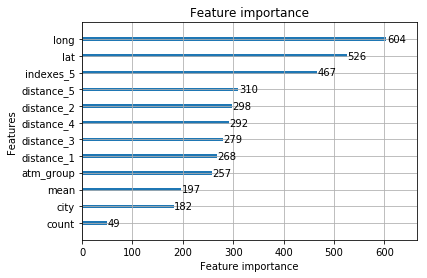

In [135]:
%matplotlib inline
lgb.plot_importance(gbm_model)

In [139]:
rmse(Y_valid, gbm_model.predict(X_valid))
scores[opt_depth-5]

0.04532998745079295

## XGBoost


In [116]:
def train_xgb(params):
    xg_reg = xgb.XGBRegressor(**params)
    xg_reg.fit(X_train, Y_train)
    score = rmse(Y_valid, xg_reg.predict(X_valid))
    return xg_reg, score

In [132]:
scores = []
models = []

conf = {
    'seed': 1,
    'subsample': 0.8,
    'max_depth': 7,
    'n_estimators': 150,
    'n_jobs': -1,
    'eval_metric': 'rmse'
}

for depth in tqdm_notebook(range(4, 8)):
    for n_estimators in range(100, 250, 20):
        conf['max_depth'] = depth
        conf['n_estimators'] = n_estimators
        model, score = train_xgb(conf)
        models.append(model)
        scores.append(score)
        print('num of estimators:', n_estimators,
              'depth:', depth, 
              'score:', score, '\n')

xgb_model = models[np.argmin(scores)]
score = scores[np.argmin(scores)]

num of estimators: 100 depth: 4 score: 0.04531861202007609 

num of estimators: 120 depth: 4 score: 0.04532025588238793 

num of estimators: 140 depth: 4 score: 0.045257277398740234 

num of estimators: 160 depth: 4 score: 0.04525335062057782 

num of estimators: 180 depth: 4 score: 0.045293398103371706 

num of estimators: 200 depth: 4 score: 0.04527966807162685 

num of estimators: 220 depth: 4 score: 0.045277013291827956 

num of estimators: 240 depth: 4 score: 0.045267857622129634 

num of estimators: 100 depth: 5 score: 0.045185090858260765 

num of estimators: 120 depth: 5 score: 0.045098364356695314 

num of estimators: 140 depth: 5 score: 0.045147800036670446 

num of estimators: 160 depth: 5 score: 0.04510405370435009 

num of estimators: 180 depth: 5 score: 0.04515937492357587 

num of estimators: 200 depth: 5 score: 0.04514452445964117 

num of estimators: 220 depth: 5 score: 0.04516996705510489 

num of estimators: 240 depth: 5 score: 0.045276631074409816 

num of estimator

0.04484156739380231 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=120, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1, silent=True, subsample=0.8)


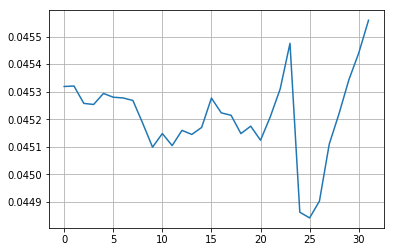

In [133]:
print(score, '\n', xgb_model)
plt.plot(scores)
plt.grid()

## Composite Models

In [146]:
av_model = AveragingModel([xgb_model, gbm_model], pretrained=True)
rmse(Y_valid, av_model.predict(X_valid))

0.044568963382856014

## Submit

In [147]:
X_test = X[~X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                        'distance_2', 'distance_3',  'distance_4', 'distance_5',
                        'indexes_5', 'mean', 'city']]

In [148]:
submit = pd.DataFrame(av_model.predict(X_test), index=test.index,columns=['target'])

In [149]:
submit.to_csv('submit.csv')